# Airbnb Price Prediction Model Analysis
**City:** Vienna, Austria  
**Data Source:** Inside Airbnb  
**Objective:** Build pricing model for Airbnb property chain

## Table of Contents
1. Data Wrangling & Feature Engineering
2. Model Training (OLS, LASSO, RF, XGBoost, LightGBM)
3. Model Comparison & Performance Analysis
4. Feature Importance Analysis
5. Validity Testing (Later Date & Other City)

In [1]:
import os
import sys
import warnings

import numpy as np

import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('../data/vienna_cleaned_september.csv')
df.head()

,source,name,description,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,neighbourhood_cleansed_Penzing,neighbourhood_cleansed_Rudolfsheim_Fnfhaus,neighbourhood_cleansed_Simmering,neighbourhood_cleansed_Wieden,neighbourhood_cleansed_Whring,host_verifications___email____phone__,host_verifications___email__,host_verifications___phone____work_email__,host_verifications___phone__,distance_to_center
0,city scrape,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,175131,2010-07-20,within an hour,100.0,95.0,0,15.0,...,0,1,0,0,0,1,0,0,0,4.365904
1,city scrape,little studio- next to citycenter- wifi- nice ...,small studio in new renovated old house and ve...,166283,2010-07-14,within an hour,100.0,100.0,1,2.0,...,0,0,0,0,0,1,0,0,0,1.122356
2,city scrape,Near Palace Schönbrunn - Apt. 4,Studio apartment for 4 persons:<br />- Bunk be...,175131,2010-07-20,within an hour,100.0,95.0,0,15.0,...,0,1,0,0,0,1,0,0,0,4.288273
3,city scrape,"Near Palace Schönbrunn, Apt. 5",Studio apartment for 4 persons:<br />- Bunk be...,175131,2010-07-20,within an hour,100.0,95.0,0,15.0,...,0,1,0,0,0,1,0,0,0,4.346107
4,city scrape,Apartment with roofterrace (#1),Our bright apartment with its own terrace over...,675182,2011-06-07,NaN,100.0,100.0,1,17.0,...,0,0,0,0,0,0,0,0,0,4.492867


In [3]:
corr_with_price = (
    df.select_dtypes(include="number")
      .corr()["price"]
      .drop("price")          # remove self-correlation
      .sort_values(ascending=False)
)

print(corr_with_price)


accommodates                                 0.353339
bedrooms                                     0.337951
beds                                         0.296828
estimated_revenue_l365d                      0.289527
bathrooms                                    0.283350
                                               ...   
estimated_occupancy_l365d                   -0.133911
room_type_Private_room                      -0.144448
property_type_Private_room_in_rental_unit   -0.163080
distance_to_center                          -0.179862
has_availability                                  NaN
Name: price, Length: 169, dtype: float64


In [4]:
cols_to_drop = corr_with_price[corr_with_price.isna()].index
df.drop(columns=cols_to_drop, inplace=True)

## Interactions

In [5]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()
    
    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))
        
        # Adjust x positions for dodge effect
        if i == 1:
            x = x + 0.2
        else:
            x = x - 0.2
            
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')
    
    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )
    
    # Remove grid
    ax.grid(False)
    plt.show()
    
    return plt

C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function mean at 0x000001904DB17920> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function std at 0x000001904DB17A60> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


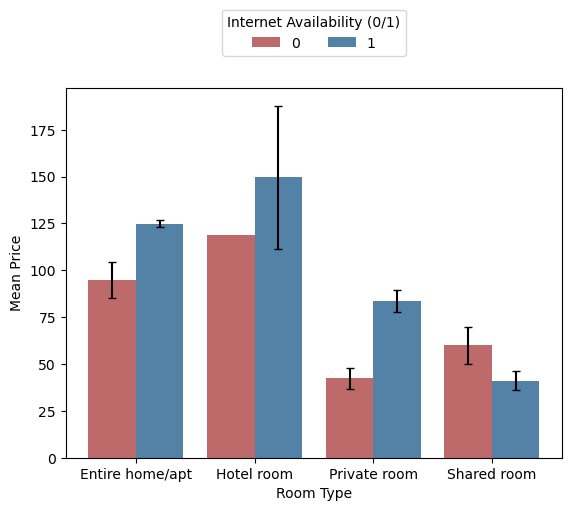

<module 'matplotlib.pyplot' from 'c:\\Users\\dcccddtcccccccc\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
price_diff_by_variables(
    df=df,
    factor_var="room_type",              # Categorical variable: Room Type
    dummy_var="amenity_wifi",        # Binary variable: Internet Availability (0 = No, 1 = Yes)
    factor_lab="Room Type",
    dummy_lab="Internet Availability (0/1)"
)

C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function mean at 0x000001904DB17920> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function std at 0x000001904DB17A60> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


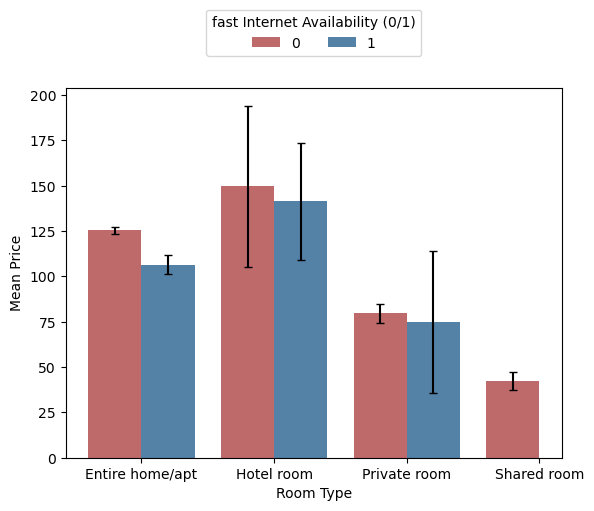

<module 'matplotlib.pyplot' from 'c:\\Users\\dcccddtcccccccc\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
price_diff_by_variables(
    df=df,
    factor_var="room_type",              # Categorical variable: Room Type
    dummy_var="amenity_fast_wifi",        # Binary variable: Internet Availability (0 = No, 1 = Yes)
    factor_lab="Room Type",
    dummy_lab="fast Internet Availability (0/1)"
)

C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function mean at 0x000001904DB17920> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function std at 0x000001904DB17A60> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


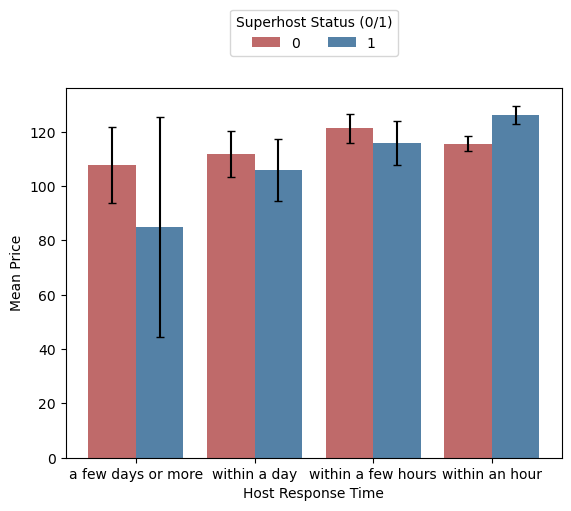

<module 'matplotlib.pyplot' from 'c:\\Users\\dcccddtcccccccc\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [8]:
price_diff_by_variables(
    df=df,
    factor_var="host_response_time",              # Categorical variable: Room Type
    dummy_var="host_is_superhost",        # Binary variable: Internet Availability (0 = No, 1 = Yes)
    factor_lab="Host Response Time",
    dummy_lab="Superhost Status (0/1)"
)

C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function mean at 0x000001904DB17920> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:3: FutureWarning: The provided callable <function std at 0x000001904DB17A60> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  stats = df.groupby([factor_var, dummy_var]).agg(
C:\Users\dcccddtcccccccc\AppData\Local\Temp\ipykernel_22704\118378295.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


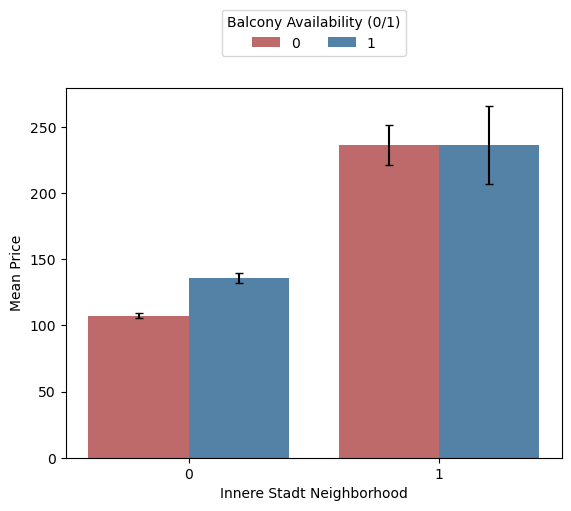

<module 'matplotlib.pyplot' from 'c:\\Users\\dcccddtcccccccc\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
price_diff_by_variables(
    df=df,
    factor_var="neighbourhood_cleansed_Innere_Stadt",              # Categorical variable: Room Type
    dummy_var="amenity_balcony",        # Binary variable: Internet Availability (0 = No, 1 = Yes)
    factor_lab="Innere Stadt Neighborhood",
    dummy_lab="Balcony Availability (0/1)"
)

## OLS

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [11]:
for col in df.columns:
    print(col)


source
name
description
host_id
host_since
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
availability_eoy
number_of_reviews_ly
estimated_occupancy_l365d
estimated_revenue_l365d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
calculated_host_listings_count
calculated_host_listings_count_entire_home

In [12]:
base1 = (
    "amenities_score",
    "beds",
    "bedrooms",
    "bathrooms",
    "accommodates",
    "days_since_hosting",
    "distance_to_center",
    "estimated_revenue_l365d",
    "number_of_reviews_ly",
)
amenity_cols = [c for c in df.columns if c.startswith("amenity_")]
neighbourhood_cols = [c for c in df.columns if c.startswith("neighbourhood_cleansed_")]
property_cols = [c for c in df.columns if c.startswith("property_type_")]
roomtype_cols = [c for c in df.columns if c.startswith("room_type_")]
hostverify_cols = [c for c in df.columns if c.startswith("host_verifications_")]
hostresponse_cols = [c for c in df.columns if c.startswith("host_response_time_")]
calculated_cols = [c for c in df.columns if c.startswith("calculated_")]
reviewscores_cols = [c for c in df.columns if c.startswith("review_scores_")]
availability_cols = [c for c in df.columns if c.startswith("availability_")]
minimumstay_cols = [c for c in df.columns if c.startswith("minimum_")]
maximumstay_cols = [c for c in df.columns if c.startswith("maximum_")]
hostcol_cols = (
    "host_is_superhost",
    "host_listings_count",
    "host_identity_verified",
    "host_response_rate",
    "host_acceptance_rate",
    "host_total_listings_count",
    "host_has_profile_pic",
)
base2 = (
  "days_since_first_review",
  "number_of_reviews",
  "days_since_last_review",
  "has_reviews",
  "reviews_per_month",
  "instant_bookable",
  "estimated_occupancy_l365d",
  "latitude",
  "longitude"
)

In [13]:

X1 = (
    "beds*bedrooms",
    "bedrooms*bathrooms",
    "beds*accommodates",
    "bedrooms*accommodates"
)

# X2: Amenities and property features interactions
X2 = (
    "amenities_score*beds",
    "amenities_score*bedrooms",
    "amenities_score*accommodates",
    "amenities_score*bathrooms"
)

# X3: Location-based interactions
X3 = (
    "distance_to_center*accommodates",
    "distance_to_center*bedrooms",
    "distance_to_center*amenities_score",
    "distance_to_center*bathrooms"
)



In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [15]:
# Set random seeds
np.random.seed(29012026)
random_state_kfold = 20250224

# Split data
df_train, df_holdout = train_test_split(df, train_size=0.8, random_state=20250224)
print(f"\nTraining set: {df_train.shape}")
print(f"Holdout set: {df_holdout.shape}")


Training set: (8104, 181)
Holdout set: (2026, 181)


In [16]:


# Define feature groups - CAREFULLY SELECTED TO AVOID MULTICOLLINEARITY
base1 = [
    "amenities_score", "beds", "bedrooms", "bathrooms", "accommodates",
    "days_since_hosting", "distance_to_center", "estimated_revenue_l365d",
    "number_of_reviews_ly", "estimated_occupancy_l365d"
]

# Amenity features (binary indicators)
amenity_cols = [c for c in df_train.columns if c.startswith("amenity_") and c != "amenities_clean"]

# Location features (one-hot encoded neighbourhoods)
neighbourhood_cols = [c for c in df_train.columns if c.startswith("neighbourhood_cleansed_")]

# Property features (one-hot encoded property types)
property_cols = [c for c in df_train.columns if c.startswith("property_type_")]

# Room type features (one-hot encoded)
roomtype_cols = [c for c in df_train.columns if c.startswith("room_type_")]

# Host verification features
hostverify_cols = [c for c in df_train.columns if c.startswith("host_verifications_")]

# Host response time features (one-hot encoded)
hostresponse_cols = [c for c in df_train.columns if c.startswith("host_response_time_")]

# Host characteristics - EXCLUDING calculated_ columns to avoid multicollinearity
hostcol_cols = [
    "host_is_superhost", "host_listings_count", "host_identity_verified",
    "host_response_rate", "host_acceptance_rate", "host_total_listings_count",
    "host_has_profile_pic"
]

# Review scores - these are NOT perfectly correlated
reviewscores_cols = [c for c in df_train.columns if c.startswith("review_scores_")]

# Availability features
availability_cols = [
    "availability_30", "availability_60", "availability_90", "availability_365"
]

# Stay requirements
stay_cols = [
    "minimum_nights", "maximum_nights"
]

# Additional base features
base2 = [
    "days_since_first_review", "number_of_reviews", "days_since_last_review",
    "has_reviews", "reviews_per_month", "instant_bookable", "latitude", "longitude"
]

# Interaction terms
X1 = ["beds*bedrooms", "bedrooms*bathrooms", "beds*accommodates", "bedrooms*accommodates"]
X2 = ["amenities_score*beds", "amenities_score*bedrooms", "amenities_score*accommodates", "amenities_score*bathrooms"]
X3 = ["distance_to_center*accommodates", "distance_to_center*bedrooms", "distance_to_center*amenities_score", "distance_to_center*bathrooms"]

# Create interaction features
print("\nCreating interaction features...")
for interaction in X1 + X2 + X3:
    feat1, feat2 = interaction.split("*")
    if feat1 in df_train.columns and feat2 in df_train.columns:
        df_train[interaction] = df_train[feat1] * df_train[feat2]
        df_holdout[interaction] = df_holdout[feat1] * df_holdout[feat2]
    else:
        print(f"Warning: Could not create {interaction}")

# Define 6 models with progressive complexity
models = {
    "Model 1": base1,
    
    "Model 2": base1 + amenity_cols + neighbourhood_cols + property_cols + roomtype_cols,
    
    "Model 3": base1 + amenity_cols + neighbourhood_cols + property_cols + roomtype_cols + \
               hostverify_cols + hostresponse_cols + hostcol_cols,
    
    "Model 4": base1 + amenity_cols + neighbourhood_cols + property_cols + roomtype_cols + \
               hostverify_cols + hostresponse_cols + hostcol_cols + reviewscores_cols + \
               availability_cols + stay_cols + base2,
    
    "Model 5": base1 + amenity_cols + neighbourhood_cols + property_cols + roomtype_cols + \
               hostverify_cols + hostresponse_cols + hostcol_cols + reviewscores_cols + \
               availability_cols + stay_cols + base2 + X1,
    
    "Model 6": base1 + amenity_cols + neighbourhood_cols + property_cols + roomtype_cols + \
               hostverify_cols + hostresponse_cols + hostcol_cols + reviewscores_cols + \
               availability_cols + stay_cols + base2 + X1 + X2 + X3
}




Creating interaction features...


In [17]:
y_train = df_train['price']
y_holdout = df_holdout['price']
n_folds = 5

results = []

print("\n" + "="*80)
print("TRAINING AND EVALUATION")
print("="*80)

for name, features in models.items():
    print(f"\n{name}")
    print(f"Number of features: {len(features)}")
    
    # Check if all features exist
    missing = [f for f in features if f not in df_train.columns]
    if missing:
        print(f"WARNING: Missing features: {missing[:5]}...")
        features = [f for f in features if f in df_train.columns]
        print(f"Using {len(features)} available features")
    
    X_train = df_train[features]
    X_holdout = df_holdout[features]
    
    # Cross-validation
    lr = LinearRegression()
    cv_scores = cross_val_score(lr, X_train, y_train, cv=n_folds, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    print(f"CV RMSE per fold: {cv_rmse.round(2)}")
    print(f"CV RMSE mean: {cv_rmse.mean():.2f} (±{cv_rmse.std():.2f})")
    
    # Train on full training set and evaluate on holdout
    lr.fit(X_train, y_train)
    y_pred_holdout = lr.predict(X_holdout)
    holdout_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred_holdout))
    
    print(f"Holdout RMSE: ${holdout_rmse:.2f}")
    
    results.append({
        'Model': name,
        'Features': len(features),
        'CV_RMSE_mean': round(cv_rmse.mean(), 2),
        'CV_RMSE_std': round(cv_rmse.std(), 2),
        'Holdout_RMSE': round(holdout_rmse, 2)
    })



TRAINING AND EVALUATION

Model 1
Number of features: 10


CV RMSE per fold: [71.53 77.83 72.23 78.87 71.85]
CV RMSE mean: 74.46 (±3.20)
Holdout RMSE: $79.31

Model 2
Number of features: 118
CV RMSE per fold: [66.28 74.18 67.69 77.65 66.76]
CV RMSE mean: 70.51 (±4.57)
Holdout RMSE: $74.88

Model 3
Number of features: 133
CV RMSE per fold: [65.64 74.13 67.17 77.09 66.16]
CV RMSE mean: 70.04 (±4.67)
Holdout RMSE: $74.28

Model 4
Number of features: 154
CV RMSE per fold: [65.06 73.43 66.15 76.31 65.93]
CV RMSE mean: 69.38 (±4.59)
Holdout RMSE: $73.11

Model 5
Number of features: 158
CV RMSE per fold: [64.74 72.79 65.97 75.77 65.46]
CV RMSE mean: 68.95 (±4.47)
Holdout RMSE: $73.14

Model 6
Number of features: 166
CV RMSE per fold: [64.41 73.19 65.93 75.97 65.36]
CV RMSE mean: 68.97 (±4.69)
Holdout RMSE: $73.15


In [18]:
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(results_df.to_string(index=False))


SUMMARY
  Model  Features  CV_RMSE_mean  CV_RMSE_std  Holdout_RMSE
Model 1        10         74.46         3.20         79.31
Model 2       118         70.51         4.57         74.88
Model 3       133         70.04         4.67         74.28
Model 4       154         69.38         4.59         73.11
Model 5       158         68.95         4.47         73.14
Model 6       166         68.97         4.69         73.15


In [21]:
from sklearn.metrics import root_mean_squared_error, r2_score
import time

# =========================
# OLS for horserace (Model 6 only)
# =========================

features_ols = models["Model 6"]

X_train_ols = df_train[features_ols]
X_holdout_ols = df_holdout[features_ols]

start = time.time()
ols = LinearRegression()
ols.fit(X_train_ols, y_train)
train_time_ols = time.time() - start

# Predictions
y_train_pred_ols = ols.predict(X_train_ols)
y_holdout_pred_ols = ols.predict(X_holdout_ols)

# Metrics
train_rmse_ols = root_mean_squared_error(y_train, y_train_pred_ols)
holdout_rmse_ols = root_mean_squared_error(y_holdout, y_holdout_pred_ols)
train_r2_ols = r2_score(y_train, y_train_pred_ols)
holdout_r2_ols = r2_score(y_holdout, y_holdout_pred_ols)

# CV RMSE (already computed above, but recompute cleanly here)
cv_scores_ols = cross_val_score(
    ols,
    X_train_ols,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)
cv_rmse_ols = np.sqrt(-cv_scores_ols).mean()

# Store for horserace
ols_results = {
    "Train RMSE": train_rmse_ols,
    "CV RMSE": cv_rmse_ols,
    "Holdout RMSE": holdout_rmse_ols,
    "Train R²": train_r2_ols,
    "Holdout R²": holdout_r2_ols,
    "Training Time (s)": train_time_ols
}
ols_results


{'Train RMSE': 67.1787014448326,
 'CV RMSE': np.float64(68.97001071569602),
 'Holdout RMSE': 73.1511698454992,
 'Train R²': 0.5112748373525369,
 'Holdout R²': 0.463175772626196,
 'Training Time (s)': 0.07130956649780273}

## LASSO

In [22]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# 1. Feature selection
# =========================
features = models["Model 6"]

X_train = df_train[features]
X_holdout = df_holdout[features]

# =========================
# 2. Pipeline
# =========================
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=10_000, random_state=2026))
])

# =========================
# 3. Hyperparameter grid
# =========================
param_grid = {
    "lasso__alpha": np.logspace(-3, 2, 30)
}

# =========================
# 4. GridSearch with CV
# =========================
grid = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

start = time.time()
grid.fit(X_train, y_train)
train_time = time.time() - start

# =========================
# 5. Best model
# =========================
best_lasso = grid.best_estimator_
best_alpha = grid.best_params_["lasso__alpha"]

# =========================
# 6. Predictions
# =========================
y_train_pred   = best_lasso.predict(X_train)
y_holdout_pred = best_lasso.predict(X_holdout)

# =========================
# 7. Metrics (RMSE + R² only)
# =========================
train_rmse   = root_mean_squared_error(y_train, y_train_pred)
cv_rmse      = np.sqrt(-grid.best_score_)
holdout_rmse = root_mean_squared_error(y_holdout, y_holdout_pred)

train_r2   = r2_score(y_train, y_train_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

# =========================
# 8. Results summary
# =========================
lasso_results = {
    "Best alpha": best_alpha,
    "Train RMSE": train_rmse,
    "CV RMSE": cv_rmse,
    "Holdout RMSE": holdout_rmse,
    "Train R²": train_r2,
    "Holdout R²": holdout_r2,
    "Training Time (s)": train_time,
    "Total Features": len(features),
    "Selected Features (non-zero)": np.sum(
        best_lasso.named_steps["lasso"].coef_ != 0
    )
}

for k, v in lasso_results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


Best alpha: 0.1172
Train RMSE: 67.2725
CV RMSE: 68.8611
Holdout RMSE: 73.0956
Train R²: 0.5099
Holdout R²: 0.4640
Training Time (s): 155.2073
Total Features: 166
Selected Features (non-zero): 140


## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# ==============================
# FEATURE SELECTION (unchanged)
# ==============================

exclude_cols = [
    'price',
    'source', 'name', 'description', 'amenities',
    'amenities_clean', 'bathrooms_text',
    'host_verifications',
]

dummy_patterns = [
    'room_type_',
    'property_type_',
    'neighbourhood_cleansed_',
    'host_verifications_'
]

for col in df_train.columns:
    if any(col.startswith(pattern) for pattern in dummy_patterns):
        exclude_cols.append(col)

features = [col for col in df_train.columns if col not in exclude_cols]

# ==============================
# PREP FUNCTION
# ==============================

def prepare_X(df):
    X = df[features].copy()

    if 'host_since' in X.columns:
        X['host_since'] = pd.to_datetime(X['host_since'], errors='coerce')
        reference_date = pd.to_datetime('2024-01-01')
        X['host_since'] = (reference_date - X['host_since']).dt.days

    categorical_cols = [
        'host_response_time',
        'property_type',
        'room_type',
        'neighbourhood_cleansed'
    ]

    for col in categorical_cols:
        if col in X.columns:
            X[col] = (
                X[col]
                .fillna('missing')
                .astype('category')
                .cat.codes
            )

    X = X.fillna(X.median(numeric_only=True))
    return X

# ==============================
# TRAIN / HOLDOUT
# ==============================

X_train = prepare_X(df_train)
y_train = df_train['price']

X_holdout = prepare_X(df_holdout)
y_holdout = df_holdout['price']

# ==============================
# GRID SEARCH
# ==============================

param_grid = {
    'n_estimators': [200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt']
}

rf = RandomForestRegressor(
    random_state=2026,
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

start = time.time()
grid.fit(X_train, y_train)
train_time = time.time() - start

best_rf = grid.best_estimator_

# ==============================
# PREDICTIONS
# ==============================

y_train_pred   = best_rf.predict(X_train)
y_holdout_pred = best_rf.predict(X_holdout)

# ==============================
# METRICS (RMSE ONLY)
# ==============================

train_rmse   = root_mean_squared_error(y_train, y_train_pred)
cv_rmse      = np.sqrt(-grid.best_score_)
holdout_rmse = root_mean_squared_error(y_holdout, y_holdout_pred)

train_r2   = r2_score(y_train, y_train_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

# ==============================
# SUMMARY
# ==============================

rf_results = {
    "Train RMSE": train_rmse,
    "CV RMSE": cv_rmse,
    "Holdout RMSE": holdout_rmse,
    "Train R²": train_r2,
    "Holdout R²": holdout_r2,
    "Training Time (s)": train_time
}

for k, v in rf_results.items():
    print(f"{k}: {v:.4f}")


Train RMSE: 23.5263
CV RMSE: 64.7499
Holdout RMSE: 65.1985
Train R²: 0.9401
Holdout R²: 0.5736
Training Time (s): 73.9205


In [24]:
rf_importance = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": best_rf.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

rf_importance.head(10)


,feature,importance
0,estimated_revenue_l365d,0.064574
1,bedrooms*bathrooms,0.039822
2,distance_to_center,0.037927
3,bedrooms*accommodates,0.034068
4,amenities_score*bedrooms,0.029284
5,distance_to_center*bathrooms,0.026483
6,amenities_score*bathrooms,0.025656
7,distance_to_center*amenities_score,0.025190
8,amenities_score*accommodates,0.020786
9,beds*bedrooms,0.020597


## CATBoost

In [25]:
from catboost import CatBoostRegressor

# ==============================
# CATEGORICAL FEATURES
# ==============================

categorical_cols = [
    'host_response_time',
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]

cat_features = [
    X_train.columns.get_loc(col)
    for col in categorical_cols
    if col in X_train.columns
]

# ==============================
# MODEL
# ==============================

cat_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=2026,
    verbose=0
)

# ==============================
# PARAM GRID (reasonable & efficient)
# ==============================

param_grid = {
    'iterations': [500],
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3, 5]
}

# ==============================
# GRID SEARCH
# ==============================

grid_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

print("Starting CatBoost GridSearchCV...")

start = time.time()
grid_cat.fit(
    X_train,
    y_train,
    cat_features=cat_features
)
train_time = time.time() - start

# ==============================
# BEST MODEL
# ==============================

best_cat = grid_cat.best_estimator_

print("\n" + "="*60)
print("BEST CATBOOST PARAMETERS")
print("="*60)

for k, v in grid_cat.best_params_.items():
    print(f"{k}: {v}")

# ==============================
# PREDICTIONS
# ==============================

y_train_pred   = best_cat.predict(X_train)
y_holdout_pred = best_cat.predict(X_holdout)

# ==============================
# METRICS (RMSE + R² ONLY)
# ==============================

train_rmse   = root_mean_squared_error(y_train, y_train_pred)
cv_rmse      = np.sqrt(-grid_cat.best_score_)
holdout_rmse = root_mean_squared_error(y_holdout, y_holdout_pred)

train_r2   = r2_score(y_train, y_train_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

# ==============================
# SUMMARY (for horserace)
# ==============================

cat_results = {
    "Train RMSE": train_rmse,
    "CV RMSE": cv_rmse,
    "Holdout RMSE": holdout_rmse,
    "Train R²": train_r2,
    "Holdout R²": holdout_r2,
    "Training Time (s)": train_time
}

print("\n" + "="*60)
print("CATBOOST PERFORMANCE SUMMARY")
print("="*60)

for k, v in cat_results.items():
    print(f"{k}: {v:.4f}")

Starting CatBoost GridSearchCV...

BEST CATBOOST PARAMETERS
depth: 6
iterations: 500
l2_leaf_reg: 3
learning_rate: 0.1

CATBOOST PERFORMANCE SUMMARY
Train RMSE: 22.8962
CV RMSE: 47.8280
Holdout RMSE: 52.5963
Train R²: 0.9432
Holdout R²: 0.7225
Training Time (s): 1088.9798


In [26]:
cat_importance = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": best_cat.get_feature_importance()
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

cat_importance.head(10)


,feature,importance
0,estimated_revenue_l365d,22.162112
1,estimated_occupancy_l365d,17.354925
2,bedrooms*bathrooms,5.526640
3,distance_to_center,5.469038
4,days_since_last_review,2.659214
5,reviews_per_month,2.645923
6,availability_365,2.414835
7,bedrooms*accommodates,2.310252
8,neighbourhood_cleansed,2.277108
9,minimum_nights_avg_ntm,2.015978


## XGBoost

In [27]:
from xgboost import XGBRegressor

# ==============================
# MODEL
# ==============================

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=2026,
    n_jobs=-1,
    tree_method="hist"   # MUCH faster, same results
)

# ==============================
# PARAMETER GRID (efficient & realistic)
# ==============================

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# ==============================
# GRID SEARCH
# ==============================

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("Starting XGBoost GridSearchCV...")

start = time.time()
grid_xgb.fit(X_train, y_train)
train_time = time.time() - start

# ==============================
# BEST MODEL
# ==============================

best_xgb = grid_xgb.best_estimator_

print("\n" + "="*60)
print("BEST XGBOOST PARAMETERS")
print("="*60)

for k, v in grid_xgb.best_params_.items():
    print(f"{k}: {v}")

# ==============================
# PREDICTIONS
# ==============================

y_train_pred   = best_xgb.predict(X_train)
y_holdout_pred = best_xgb.predict(X_holdout)

# ==============================
# METRICS (RMSE + R² ONLY)
# ==============================

train_rmse   = root_mean_squared_error(y_train, y_train_pred)
cv_rmse      = np.sqrt(-grid_xgb.best_score_)
holdout_rmse = root_mean_squared_error(y_holdout, y_holdout_pred)

train_r2   = r2_score(y_train, y_train_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

# ==============================
# SUMMARY (for horserace)
# ==============================

xgb_results = {
    "Train RMSE": train_rmse,
    "CV RMSE": cv_rmse,
    "Holdout RMSE": holdout_rmse,
    "Train R²": train_r2,
    "Holdout R²": holdout_r2,
    "Training Time (s)": train_time
}

print("\n" + "="*60)
print("XGBOOST PERFORMANCE SUMMARY")
print("="*60)

for k, v in xgb_results.items():
    print(f"{k}: {v:.4f}")


Starting XGBoost GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

BEST XGBOOST PARAMETERS
colsample_bytree: 0.8
learning_rate: 0.05
max_depth: 6
n_estimators: 500
subsample: 0.8

XGBOOST PERFORMANCE SUMMARY
Train RMSE: 10.5033
CV RMSE: 48.7853
Holdout RMSE: 52.7149
Train R²: 0.9881
Holdout R²: 0.7212
Training Time (s): 43.0217


In [28]:
xgb_importance = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": best_xgb.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

xgb_importance.head(10)


,feature,importance
0,bedrooms*bathrooms,0.067203
1,bedrooms*accommodates,0.048690
2,room_type,0.039256
3,estimated_occupancy_l365d,0.029384
4,estimated_revenue_l365d,0.028078
5,instant_bookable,0.024778
6,distance_to_center,0.023819
7,amenity_fast_wifi,0.022223
8,amenity_tv,0.021560
9,host_identity_verified,0.019775


## MODEL COMPARISON - HORSERACE TABLE

In [29]:
horserace = pd.DataFrame(
    [ols_results, lasso_results, rf_results, cat_results, xgb_results],
    index=["OLS", "LASSO", "Random Forest", "CatBoost", "XGBoost"]
)

horserace = horserace.sort_values("Holdout RMSE")
horserace.round(2)


,Train RMSE,CV RMSE,Holdout RMSE,Train R²,Holdout R²,Training Time (s),Best alpha,Total Features,Selected Features (non-zero)
CatBoost,22.90,47.83,52.60,0.94,0.72,1088.98,NaN,NaN,NaN
XGBoost,10.50,48.79,52.71,0.99,0.72,43.02,NaN,NaN,NaN
Random Forest,23.53,64.75,65.20,0.94,0.57,73.92,NaN,NaN,NaN
LASSO,67.27,68.86,73.10,0.51,0.46,155.21,0.12,166.0,140.0
OLS,67.18,68.97,73.15,0.51,0.46,0.07,NaN,NaN,NaN
